# Forecasting with sktime

In this tutorial, you'll learn about how to

* use statistical models,
* build composite models, including ensembling and pipelining,
* apply machine learning models to forecasting. 

## Preliminaries

In [1]:
import matplotlib.pyplot as plt
from sktime.datasets import load_airline
from sktime.utils.plotting.forecasting import plot_ys
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.performance_metrics.forecasting import smape_loss
import pandas as pd
import numpy as np

%matplotlib inline

def print_smape_loss(y_test, y_pred):
    print(f"sMAPE: {smape_loss(y_pred, y_test).round(2)}")

## Data
For this tutorial, we will use the famous Box-Jenkins airline data set, which shows the number of international airline
passengers per month from 1949-1960.

As well as using the original time series (which is a classic example of a *multiplicative* time series), we will create an *additive* time series by performing a log-transform on the original data, so we may compare forecasters against both types of model.

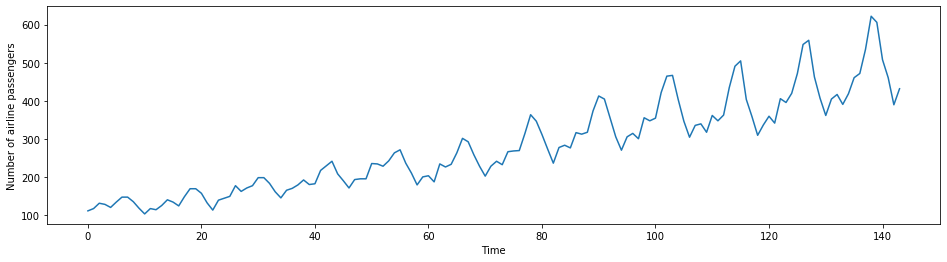

In [2]:
y = load_airline()
fig, ax = plot_ys(y)
ax.set(xlabel="Time", ylabel="Number of airline passengers");

Next we will define a forecasting task. We will try to predict the last 3 years of data, using the previous years as training data. Each point in the series represents a month, so we should hold out the last 36 points as test data, and use 36-step ahead forecasting horizon to evaluate forecasting performance.

We can split the data as follows:

In [3]:
y_train, y_test = temporal_train_test_split(y, test_size=36)
print(y_train.shape[0], y_test.shape[0])

108 36


We can specify the forecasting horizon as a simple numpy array of steps ahead relative to the end of the training series:

In [4]:
fh = np.arange(len(y_test)) + 1
fh

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36])

## Forecasting

Like in scikit-learn, in order to make forecasts, we need to specify/construct a model, fit it to the training data, and call predict to generate forecasts for the given forecasting horizon. 

sktime comes with several forecasting algorithms (or forecasters) and tools for composite model building. All forecaster share a common interface. Forecasters are trained on a single series of data and make forecasts for the provided forecasting horizon.

### Naïve baselines
Let's start with two simple forecasting models: first, we always predict the last value observed in the training series 

In [5]:
from sktime.forecasting.naive import NaiveForecaster

In [6]:
forecaster = NaiveForecaster(strategy="last")
forecaster.fit(y_train)
y_last = forecaster.predict(fh)
print_smape_loss(y_test, y_last)

sMAPE: 0.23


In [7]:
forecaster = NaiveForecaster(strategy="seasonal_last", sp=12)
forecaster.fit(y_train)
seasonal_last = forecaster.predict(fh)
print_smape_loss(y_test, seasonal_last)

sMAPE: 0.15


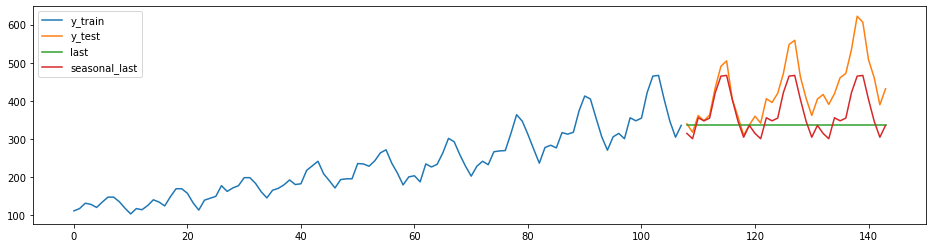

In [8]:
plot_ys(y_train, y_test, y_last, seasonal_last, labels=["y_train", "y_test", "last", "seasonal_last"]);

### Statistical forecasters

sktime has a number of statistical forecasting algorithms, based on implementations in statsmodels. For example, to use exponential smoothing with an additive trend component and multiplicative seasonality, we can write:

sMAPE: 0.05


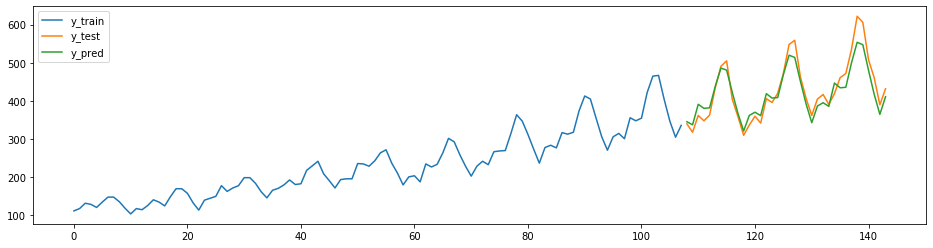

In [9]:
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
forecaster = ExponentialSmoothing(trend="add", seasonal="multiplicative", sp=12)
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_ys(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"]);
print_smape_loss(y_test, y_pred)

We also interface pmdarima, a Python package for automatically selecting the best ARIMA model. 

sMAPE: 0.08


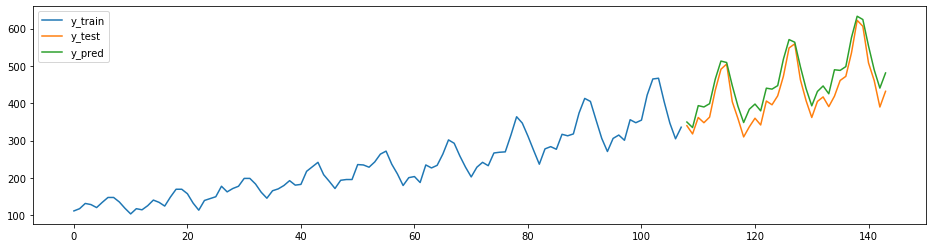

In [10]:
from sktime.forecasting.arima import AutoARIMA
forecaster = AutoARIMA(sp=12, suppress_warnings=True)
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_ys(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"]);
print_smape_loss(y_test, y_pred)

## Compositite model building 

sktime provides a modular API for composite model building which is compatible with scikit-learn. 

### Ensembling
Like scikit-learn, sktime provides a meta-forecaster to ensemble multiple forecasting algorithms. For example, we can combine different variants of exponential smoothing as follows:

/Users/mloning/.conda/envs/sktime-dev/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


sMAPE: 0.07


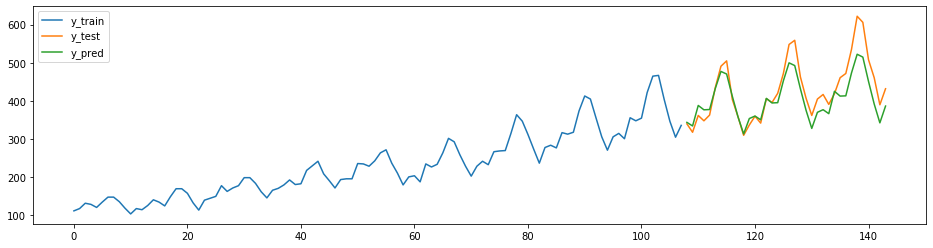

In [11]:
from sktime.forecasting.compose import EnsembleForecaster
forecaster = EnsembleForecaster([
    ("ses", ExponentialSmoothing(seasonal="multiplicative", sp=12)),
    ("holt", ExponentialSmoothing(trend="add", damped=False, seasonal="multiplicative", sp=12)),
    ("damped", ExponentialSmoothing(trend="add", damped=True, seasonal="multiplicative", sp=12))
])
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_ys(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"]);
print_smape_loss(y_test, y_pred)

### Reduction to regression
Forecasting is often solved via regression by first transforming the data into the required tabular format, so that we can apply any tabular regression algorithm, an approach called reduction. sktime provide a meta-estimator for reduction from forecating to regression, which is compatible with scikit-learn, so that we can use any scikit-learn regressor to solve our forecasting problem. 

sMAPE: 0.15


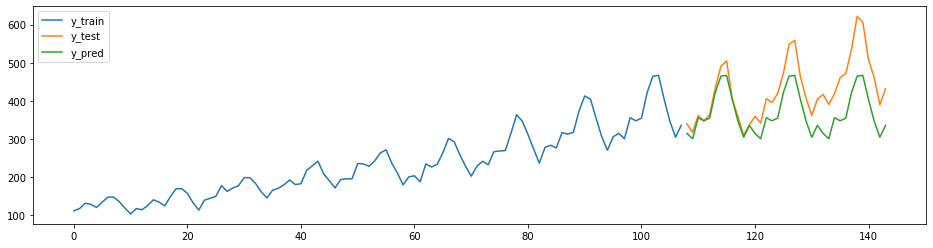

In [12]:
from sktime.forecasting.compose import ReducedRegressionForecaster
from sklearn.neighbors import KNeighborsRegressor

regressor = KNeighborsRegressor(n_neighbors=1)
forecaster = ReducedRegressionForecaster(regressor=regressor, window_length=10, strategy="recursive")
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_ys(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"]);
print_smape_loss(y_test, y_pred)

To better understand the prior data transformation, we can call the `transform` method, which transforms the single series into a tabular feature matrix of lagged values and a target vector.

In [13]:
X_train_tab, y_train_tab = forecaster.transform(y_train)
print(X_train_tab.shape, y_train_tab.shape)

(98, 10) (98, 1)


Internally, sktime uses a temporal time series splitter, similar to the cross-validation splitter in scikit-learn: 

In [14]:
from sktime.forecasting.model_selection import SlidingWindowSplitter
cv = SlidingWindowSplitter(window_length=10, start_with_window=True)
for input_window, output_window in cv.split(y_train):
    print(input_window, output_window)

[0 1 2 3 4 5 6 7 8 9] [10]
[ 1  2  3  4  5  6  7  8  9 10] [11]
[ 2  3  4  5  6  7  8  9 10 11] [12]
[ 3  4  5  6  7  8  9 10 11 12] [13]
[ 4  5  6  7  8  9 10 11 12 13] [14]
[ 5  6  7  8  9 10 11 12 13 14] [15]
[ 6  7  8  9 10 11 12 13 14 15] [16]
[ 7  8  9 10 11 12 13 14 15 16] [17]
[ 8  9 10 11 12 13 14 15 16 17] [18]
[ 9 10 11 12 13 14 15 16 17 18] [19]
[10 11 12 13 14 15 16 17 18 19] [20]
[11 12 13 14 15 16 17 18 19 20] [21]
[12 13 14 15 16 17 18 19 20 21] [22]
[13 14 15 16 17 18 19 20 21 22] [23]
[14 15 16 17 18 19 20 21 22 23] [24]
[15 16 17 18 19 20 21 22 23 24] [25]
[16 17 18 19 20 21 22 23 24 25] [26]
[17 18 19 20 21 22 23 24 25 26] [27]
[18 19 20 21 22 23 24 25 26 27] [28]
[19 20 21 22 23 24 25 26 27 28] [29]
[20 21 22 23 24 25 26 27 28 29] [30]
[21 22 23 24 25 26 27 28 29 30] [31]
[22 23 24 25 26 27 28 29 30 31] [32]
[23 24 25 26 27 28 29 30 31 32] [33]
[24 25 26 27 28 29 30 31 32 33] [34]
[25 26 27 28 29 30 31 32 33 34] [35]
[26 27 28 29 30 31 32 33 34 35] [36]
[27 28 29 3

## Tuning
The `window_length` and `strategy` arguments are hyper-parameters which we may want to optimise. 

In [15]:
from sktime.forecasting.model_selection import ForecastingGridSearchCV
from sktime.forecasting.model_selection import SingleWindowSplitter

forecaster = ReducedRegressionForecaster(regressor=regressor, window_length=15, strategy="recursive")
param_grid = {"window_length": [5, 10, 15]}

# we fit the forecaster on the initial window, and then use temporal cross-validation to find the optimal parameter
cv = SlidingWindowSplitter(initial_window=int(len(y_train) * 0.5))
gscv = ForecastingGridSearchCV(forecaster, cv=cv, param_grid=param_grid)
gscv.fit(y_train)
y_pred = gscv.predict(fh)

sMAPE: 0.14


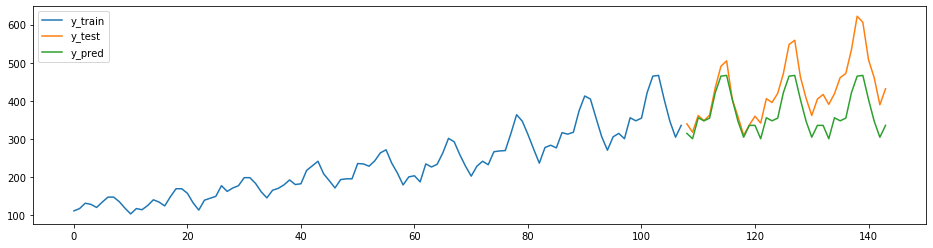

In [16]:
plot_ys(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"]);
print_smape_loss(y_test, y_pred)

In [17]:
gscv.best_params_

{'window_length': 15}

You could of course also try to tune the regressor inside `ReducedRegressionForecaster` using scikit-learn's `GridSearchCV`.

### Detrending
The reduction approach above does not take any seasonal or trend into account, but we can easily specify a pipeline which first detrends the data. 

sktime provides a generic detrender, a transformer which uses any forecaster and returns the in-sample residuals of the forecaster's predicted values. For example, to remove the linear trend of a time series, we can write:

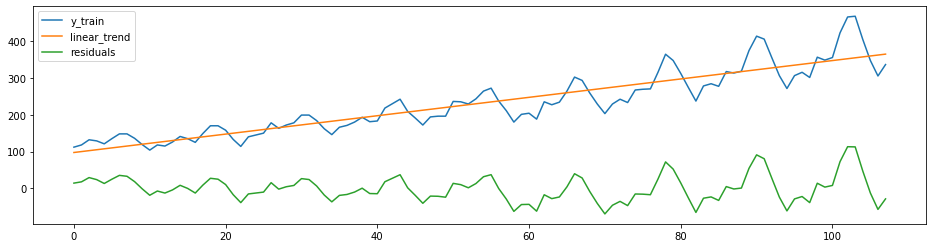

In [18]:
from sktime.forecasting.trend import PolynomialTrendForecaster
from sktime.transformers.detrend import Detrender

# linear trend forecasting
forecaster = PolynomialTrendForecaster(degree=1)
y_pred = forecaster.fit(y_train).predict(fh=-np.arange(len(y_train)))  # in-sample predictions

# liner detrending 
transformer = Detrender(forecaster=forecaster)
yt = transformer.fit_transform(y_train)
plot_ys(y_train, y_pred, yt, labels=["y_train", "linear_trend", "residuals"]);

### Pipelining

Let's use the detrender in a pipeline together with de-seasonalisation. Note that in forecasting, when we apply data transformations before fitting, we need to apply the inverse transformation to the predicted values. For this purpose, we provide the following pipeline class:

sMAPE: 0.04


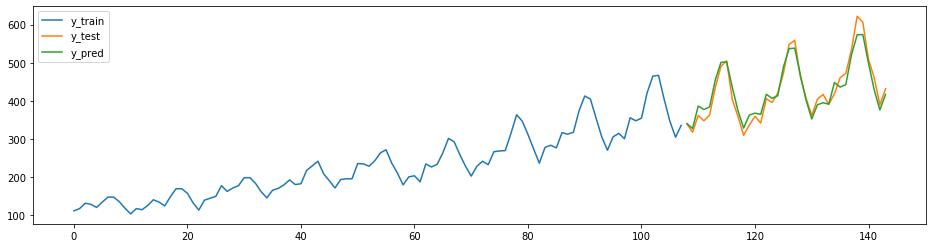

In [19]:
from sktime.forecasting.compose import TransformedTargetForecaster
from sktime.transformers.detrend import Deseasonaliser

forecaster = TransformedTargetForecaster([
    ("deseasonalise", Deseasonaliser(model="multiplicative", sp=12)),
    ("detrend", Detrender(forecaster=PolynomialTrendForecaster(degree=1))),
    ("forecast", ReducedRegressionForecaster(regressor=regressor, window_length=15, strategy="recursive"))
])
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_ys(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"]);
print_smape_loss(y_test, y_pred)

## Dynamic forecasts
For model evaluation, we sometimes want to evaluate multiple forecasts, using temporal cross-validation with a sliding window over the test data. For this purpose, all forecasters in sktime have a `update_predict` method. Here we make repeated single-step ahead forecasts over the test set.

sMAPE: 0.1


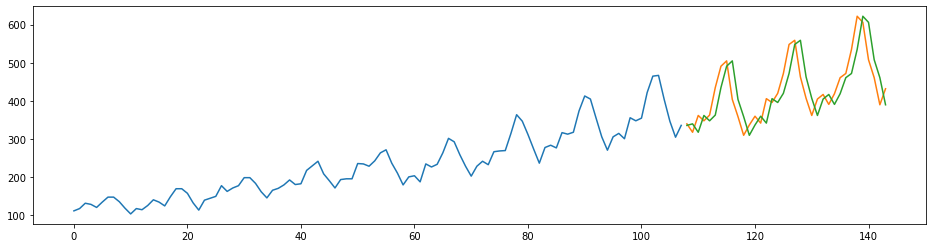

In [20]:
forecaster = NaiveForecaster(strategy="last")
forecaster.fit(y_train)
cv = SlidingWindowSplitter(fh=1)
y_pred = forecaster.update_predict(y_test, cv)
print_smape_loss(y_test, y_pred)
plot_ys(y_train, y_test, y_pred);

For a single update, you can use the `update` method. 

## Prediction intervals
So far, we've only looked at point forecasts. In many cases, we're also interested in prediction intervals. sktime's interface support prediction intervals. Here, we use the Theta forecasting algorithm: 

sMAPE: 0.09


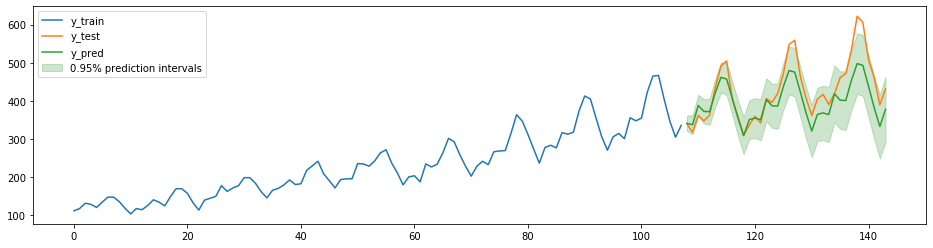

In [21]:
from sktime.forecasting.theta import ThetaForecaster
forecaster = ThetaForecaster(sp=12)
forecaster.fit(y_train)
alpha = 0.05  # 95% prediction intervals
y_pred, pred_ints = forecaster.predict(fh, return_pred_int=True, alpha=alpha)
print_smape_loss(y_test, y_pred)

fig, ax = plot_ys(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
ax.fill_between(y_pred.index, pred_ints["lower"], pred_ints["upper"], alpha=0.2, color="green", label=f"{1 - alpha}% prediction intervals")
plt.legend();